# FaceWatch 프로젝트 분석 노트북

이 노트북은 FaceWatch 프로젝트의 임베딩 데이터를 확인하고 분석하는 도구입니다.

## 주요 기능
- 임베딩 파일 구조 확인
- 갤러리 로드 및 통계 확인
- Bank vs Centroid 비교
- 인물 간 유사도 분석
- 임베딩 분포 시각화


In [2]:
# 프로젝트 루트 디렉토리로 작업 디렉토리 설정
import os
import sys
from pathlib import Path

# notebooks 폴더에서 실행 중이면 상위 폴더로 이동
if Path.cwd().name == "notebooks":
    os.chdir("..")
    print(f"작업 디렉토리: {os.getcwd()}")
else:
    print(f"현재 작업 디렉토리: {os.getcwd()}")


작업 디렉토리: c:\FaceWatch


In [3]:
# 필요한 라이브러리 import
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import pandas as pd

# 프로젝트 유틸리티 import
sys.path.insert(0, str(Path("src")))
from utils.gallery_loader import load_gallery, match_with_bank, match_with_bank_detailed, l2_normalize

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


## 1. 임베딩 파일 구조 확인


In [4]:
# 임베딩 폴더 확인
emb_dir = Path("outputs/embeddings")

if not emb_dir.exists():
    print(f"[ERROR] 임베딩 폴더를 찾을 수 없음: {emb_dir}")
    print("먼저 face_enroll_final.py를 실행하여 임베딩을 생성하세요.")
else:
    print(f"[OK] 임베딩 폴더: {emb_dir}")
    print()
    
    # 사람별 폴더 확인
    person_dirs = [d for d in emb_dir.iterdir() if d.is_dir()]
    print(f"등록된 인물 수: {len(person_dirs)}")
    print()
    
    for person_dir in sorted(person_dirs):
        person_id = person_dir.name
        bank_path = person_dir / "bank.npy"
        centroid_path = person_dir / "centroid.npy"
        
        print(f"[{person_id}]")
        if bank_path.exists():
            bank = np.load(bank_path)
            print(f"   - bank.npy: {bank.shape} ({bank.shape[0]}개 임베딩)")
        if centroid_path.exists():
            centroid = np.load(centroid_path)
            print(f"   - centroid.npy: {centroid.shape}")
        print()


[OK] 임베딩 폴더: outputs\embeddings

등록된 인물 수: 11

[danielle]
   - bank.npy: (1, 512) (1개 임베딩)
   - centroid.npy: (512,)

[hani]
   - bank.npy: (1, 512) (1개 임베딩)
   - centroid.npy: (512,)

[harin]
   - bank.npy: (1, 512) (1개 임베딩)
   - centroid.npy: (512,)

[hong]
   - bank.npy: (1, 512) (1개 임베딩)
   - centroid.npy: (512,)

[hyein]
   - bank.npy: (1, 512) (1개 임베딩)
   - centroid.npy: (512,)

[ja]
   - bank.npy: (1, 512) (1개 임베딩)
   - centroid.npy: (512,)

[js]
   - bank.npy: (1, 512) (1개 임베딩)
   - centroid.npy: (512,)

[jw]
   - bank.npy: (1, 512) (1개 임베딩)
   - centroid.npy: (512,)

[minji]
   - bank.npy: (1, 512) (1개 임베딩)
   - centroid.npy: (512,)

[yh]
   - bank.npy: (1, 512) (1개 임베딩)
   - centroid.npy: (512,)

[yujin]
   - bank.npy: (1, 512) (1개 임베딩)
   - centroid.npy: (512,)



## 2. 갤러리 로드 및 통계 확인


In [5]:
# 갤러리 로드 (Bank 우선)
gallery = load_gallery(emb_dir, use_bank=True)

print(f"갤러리 로드 완료: {len(gallery)}명")
print()

# 각 인물의 임베딩 정보 출력
gallery_stats = []
for person_id, emb_data in sorted(gallery.items()):
    if emb_data.ndim == 2:
        emb_type = "Bank"
        emb_count = emb_data.shape[0]
        emb_dim = emb_data.shape[1]
    else:
        emb_type = "Centroid"
        emb_count = 1
        emb_dim = emb_data.shape[0]
    
    gallery_stats.append({
        "person_id": person_id,
        "type": emb_type,
        "count": emb_count,
        "dimension": emb_dim
    })
    
    print(f"{person_id:10s}: {emb_type:8s} ({emb_count:3d}개 임베딩, {emb_dim}차원)")

# 통계를 DataFrame으로 변환
df_stats = pd.DataFrame(gallery_stats)
print()
print("=" * 60)
print("갤러리 통계 요약")
print("=" * 60)
print(df_stats.to_string(index=False))


갤러리 로드 완료: 11명

danielle  : Bank     (  1개 임베딩, 512차원)
hani      : Bank     (  1개 임베딩, 512차원)
harin     : Bank     (  1개 임베딩, 512차원)
hong      : Bank     (  1개 임베딩, 512차원)
hyein     : Bank     (  1개 임베딩, 512차원)
ja        : Bank     ( 38개 임베딩, 512차원)
js        : Bank     (  9개 임베딩, 512차원)
jw        : Bank     ( 18개 임베딩, 512차원)
minji     : Bank     (  1개 임베딩, 512차원)
yh        : Bank     ( 41개 임베딩, 512차원)
yujin     : Bank     (  1개 임베딩, 512차원)

갤러리 통계 요약
person_id type  count  dimension
 danielle Bank      1        512
     hani Bank      1        512
    harin Bank      1        512
     hong Bank      1        512
    hyein Bank      1        512
       ja Bank     38        512
       js Bank      9        512
       jw Bank     18        512
    minji Bank      1        512
       yh Bank     41        512
    yujin Bank      1        512


## 3. Bank vs Centroid 비교


In [6]:
# 특정 인물의 Bank와 Centroid 비교
person_id = "hani"  # 비교할 인물 ID 변경 가능

person_dir = emb_dir / person_id
bank_path = person_dir / "bank.npy"
centroid_path = person_dir / "centroid.npy"

if bank_path.exists() and centroid_path.exists():
    bank = np.load(bank_path)
    centroid = np.load(centroid_path)
    
    # Centroid 계산 (Bank의 평균)
    calculated_centroid = bank.mean(axis=0)
    calculated_centroid = l2_normalize(calculated_centroid)
    
    print(f"인물: {person_id}")
    print(f"Bank 크기: {bank.shape}")
    print(f"Centroid 크기: {centroid.shape}")
    print()
    
    # 저장된 Centroid와 계산된 Centroid 비교
    similarity = float(np.dot(centroid, calculated_centroid))
    print(f"저장된 Centroid vs 계산된 Centroid 유사도: {similarity:.6f}")
    print()
    
    # Bank 내부 임베딩 간 유사도 분포
    if bank.shape[0] > 1:
        bank_normalized = bank / (np.linalg.norm(bank, axis=1, keepdims=True) + 1e-6)
        similarities = np.dot(bank_normalized, bank_normalized.T)
        # 대각선 제거 (자기 자신과의 유사도)
        mask = ~np.eye(similarities.shape[0], dtype=bool)
        bank_similarities = similarities[mask]
        
        print(f"Bank 내부 임베딩 간 유사도 통계:")
        print(f"  평균: {bank_similarities.mean():.4f}")
        print(f"  최소: {bank_similarities.min():.4f}")
        print(f"  최대: {bank_similarities.max():.4f}")
        print(f"  표준편차: {bank_similarities.std():.4f}")
else:
    print(f"[ERROR] {person_id}의 Bank 또는 Centroid 파일을 찾을 수 없습니다.")


인물: hani
Bank 크기: (1, 512)
Centroid 크기: (512,)

저장된 Centroid vs 계산된 Centroid 유사도: 1.000000



## 4. 인물 간 유사도 매트릭스


C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\1590488101.py:43: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\1590488101.py:43: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\1590488101.py:43: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\1590488101.py:43: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\1590488101.py:43: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\1590488101.py:43: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  plt.tight_layout()
C:

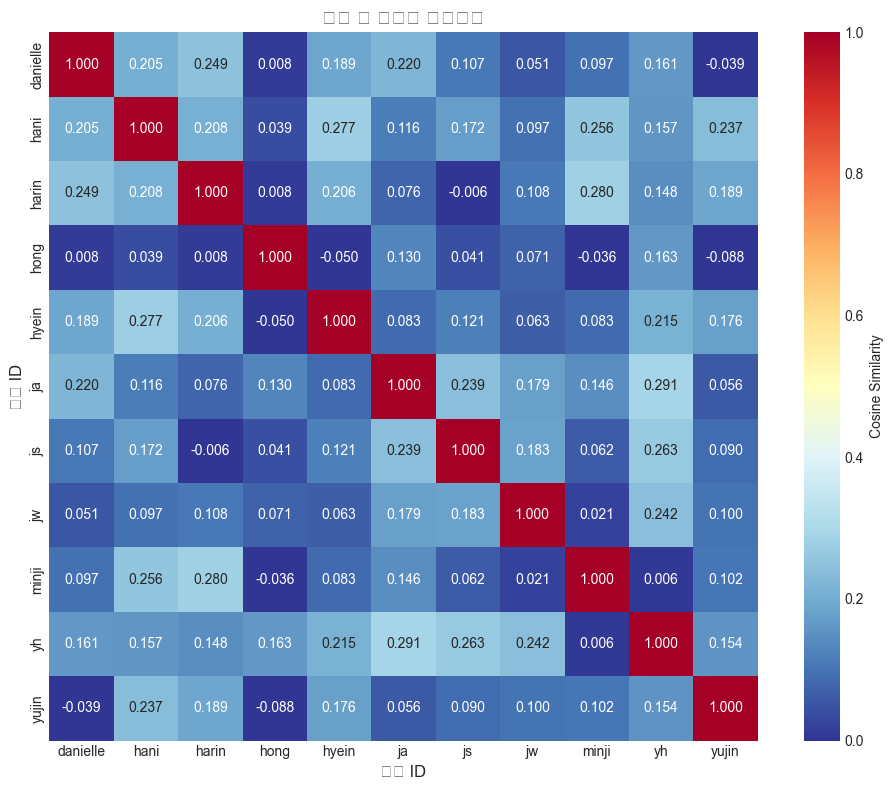

인물 간 유사도 통계:
  평균: 0.1259
  최소: -0.0877
  최대: 0.2915
  표준편차: 0.0926


In [7]:
# 모든 인물 간 유사도 계산
person_ids = sorted(gallery.keys())
n_persons = len(person_ids)

if n_persons > 1:
    similarity_matrix = np.zeros((n_persons, n_persons))
    
    for i, person_id1 in enumerate(person_ids):
        for j, person_id2 in enumerate(person_ids):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                emb1 = gallery[person_id1]
                emb2 = gallery[person_id2]
                
                # Bank인 경우 최대 유사도 사용
                if emb1.ndim == 2:
                    sims1 = np.dot(emb1, emb2.T if emb2.ndim == 2 else emb2)
                    max_sim = float(np.max(sims1))
                elif emb2.ndim == 2:
                    sims2 = np.dot(emb1, emb2.T)
                    max_sim = float(np.max(sims2))
                else:
                    max_sim = float(np.dot(emb1, emb2))
                
                similarity_matrix[i, j] = max_sim
    
    # 히트맵 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, 
                xticklabels=person_ids, 
                yticklabels=person_ids,
                annot=True, 
                fmt='.3f',
                cmap='RdYlBu_r',
                vmin=0, 
                vmax=1,
                square=True,
                cbar_kws={'label': 'Cosine Similarity'})
    plt.title('인물 간 유사도 매트릭스', fontsize=14, fontweight='bold')
    plt.xlabel('인물 ID', fontsize=12)
    plt.ylabel('인물 ID', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # 통계 출력
    print("인물 간 유사도 통계:")
    mask = ~np.eye(n_persons, dtype=bool)
    off_diagonal = similarity_matrix[mask]
    print(f"  평균: {off_diagonal.mean():.4f}")
    print(f"  최소: {off_diagonal.min():.4f}")
    print(f"  최대: {off_diagonal.max():.4f}")
    print(f"  표준편차: {off_diagonal.std():.4f}")
else:
    print("인물이 1명만 있어서 유사도 비교를 할 수 없습니다.")


## 5. 임베딩 값 분포 시각화


hani - Bank 임베딩 (1개)


C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\1964416552.py:75: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\1964416552.py:75: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\1964416552.py:75: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\1964416552.py:75: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\1964416552.py:75: UserWarning: Glyph 46304 (\N{HANGUL SYLLABLE DEUN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\1964416552.py:75: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) Arial.
  plt.tight_layout()

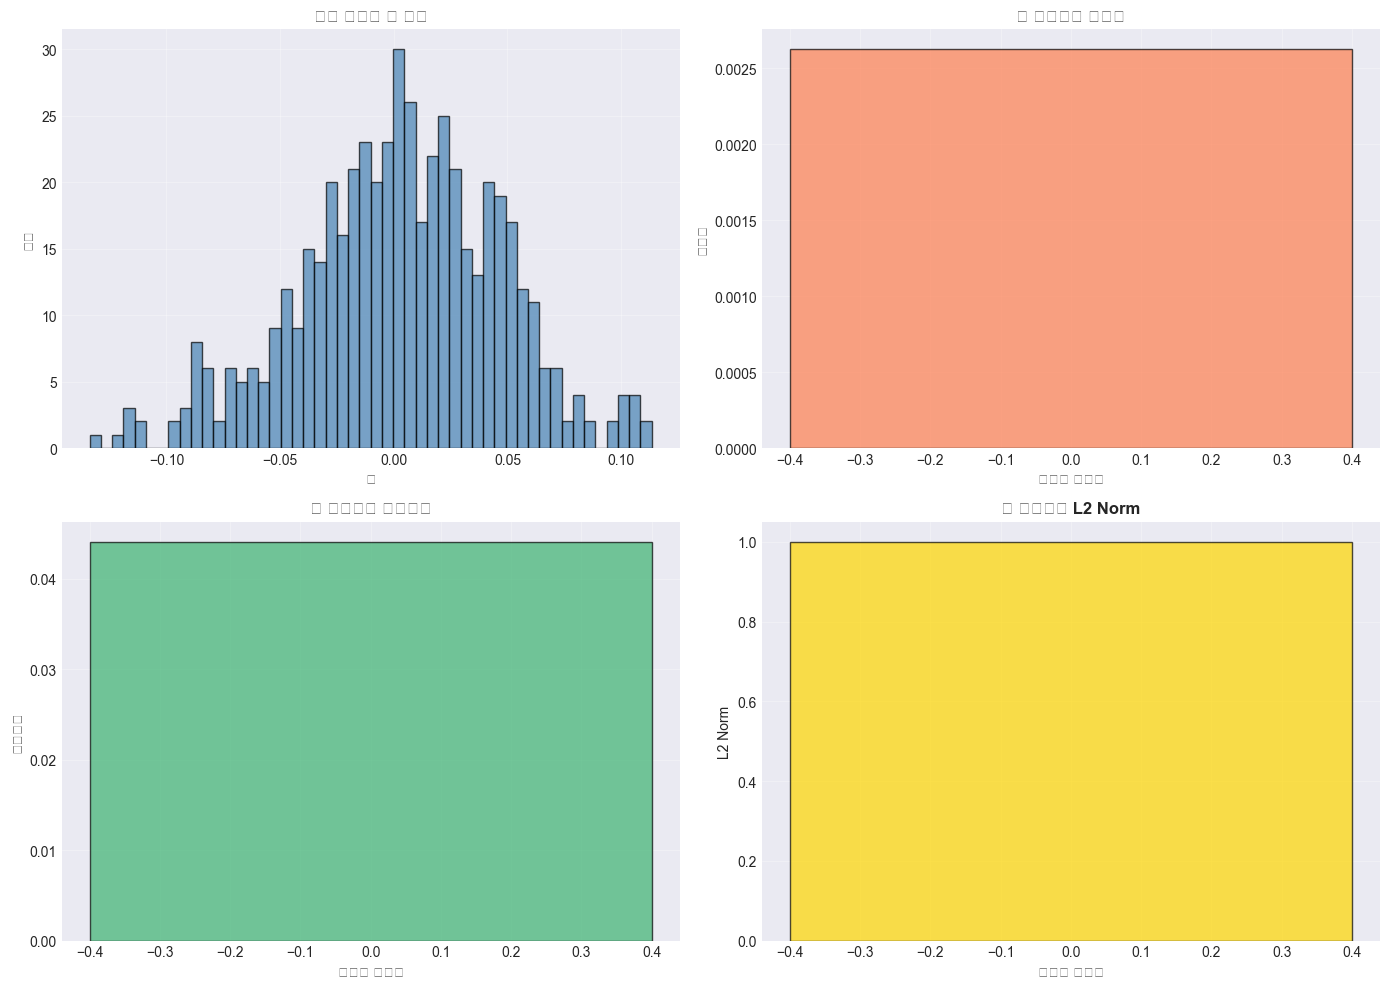


통계:
  전체 평균: 0.002625
  전체 표준편차: 0.044116
  L2 norm 평균: 0.999999


In [8]:
# 특정 인물의 임베딩 분포 확인
person_id = "hani"  # 확인할 인물 ID 변경 가능

if person_id in gallery:
    emb_data = gallery[person_id]
    
    # Centroid인 경우
    if emb_data.ndim == 1:
        emb = emb_data
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(emb, bins=50, color="steelblue", alpha=0.7, edgecolor='black')
        plt.title(f"{person_id} - Centroid 임베딩 값 분포", fontweight='bold')
        plt.xlabel("값")
        plt.ylabel("빈도")
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(emb, alpha=0.7, linewidth=0.5)
        plt.title(f"{person_id} - Centroid 임베딩 벡터", fontweight='bold')
        plt.xlabel("차원 인덱스")
        plt.ylabel("값")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"통계:")
        print(f"  평균: {emb.mean():.6f}")
        print(f"  표준편차: {emb.std():.6f}")
        print(f"  최소값: {emb.min():.6f}")
        print(f"  최대값: {emb.max():.6f}")
        print(f"  L2 norm: {np.linalg.norm(emb):.6f}")
    
    # Bank인 경우
    else:
        print(f"{person_id} - Bank 임베딩 ({emb_data.shape[0]}개)")
        
        # 각 임베딩의 통계
        means = emb_data.mean(axis=1)
        stds = emb_data.std(axis=1)
        norms = np.linalg.norm(emb_data, axis=1)
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 히스토그램: 모든 임베딩 값
        axes[0, 0].hist(emb_data.flatten(), bins=50, color="steelblue", alpha=0.7, edgecolor='black')
        axes[0, 0].set_title("모든 임베딩 값 분포", fontweight='bold')
        axes[0, 0].set_xlabel("값")
        axes[0, 0].set_ylabel("빈도")
        axes[0, 0].grid(True, alpha=0.3)
        
        # 각 임베딩의 평균값
        axes[0, 1].bar(range(len(means)), means, color="coral", alpha=0.7, edgecolor='black')
        axes[0, 1].set_title("각 임베딩의 평균값", fontweight='bold')
        axes[0, 1].set_xlabel("임베딩 인덱스")
        axes[0, 1].set_ylabel("평균값")
        axes[0, 1].grid(True, alpha=0.3)
        
        # 각 임베딩의 표준편차
        axes[1, 0].bar(range(len(stds)), stds, color="mediumseagreen", alpha=0.7, edgecolor='black')
        axes[1, 0].set_title("각 임베딩의 표준편차", fontweight='bold')
        axes[1, 0].set_xlabel("임베딩 인덱스")
        axes[1, 0].set_ylabel("표준편차")
        axes[1, 0].grid(True, alpha=0.3)
        
        # 각 임베딩의 L2 norm
        axes[1, 1].bar(range(len(norms)), norms, color="gold", alpha=0.7, edgecolor='black')
        axes[1, 1].set_title("각 임베딩의 L2 Norm", fontweight='bold')
        axes[1, 1].set_xlabel("임베딩 인덱스")
        axes[1, 1].set_ylabel("L2 Norm")
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n통계:")
        print(f"  전체 평균: {emb_data.mean():.6f}")
        print(f"  전체 표준편차: {emb_data.std():.6f}")
        print(f"  L2 norm 평균: {norms.mean():.6f}")
else:
    print(f"[ERROR] {person_id}를 갤러리에서 찾을 수 없습니다.")


## 6. 테스트 얼굴과 갤러리 매칭 테스트


In [9]:
# InsightFace를 사용하여 테스트 이미지에서 얼굴 임베딩 추출
from insightface.app import FaceAnalysis
from utils.device_config import get_device_id, safe_prepare_insightface
import cv2

# 테스트 이미지 경로 (변경 가능)
test_image_path = "images/source/test.jpg"  # 또는 다른 이미지 경로

if Path(test_image_path).exists():
    # InsightFace 초기화
    device_id = get_device_id()
    app = FaceAnalysis(name="buffalo_l")
    safe_prepare_insightface(app, device_id, det_size=(640, 640))
    
    # 이미지 로드
    img = cv2.imread(test_image_path)
    if img is None:
        print(f"[ERROR] 이미지를 읽을 수 없음: {test_image_path}")
    else:
        print(f"[OK] 이미지 로드: {test_image_path}")
        print(f"   이미지 크기: {img.shape}")
        print()
        
        # 얼굴 검출
        faces = app.get(img)
        print(f"감지된 얼굴 수: {len(faces)}")
        print()
        
        if len(faces) > 0:
            # 각 얼굴에 대해 매칭 테스트
            for i, face in enumerate(faces):
                face_emb = face.embedding.astype("float32")
                
                # 상세 매칭 정보
                best_id, best_sim, second_sim = match_with_bank_detailed(face_emb, gallery)
                sim_gap = best_sim - second_sim if second_sim > -1 else best_sim
                
                print(f"[얼굴 {i+1}]")
                print(f"  매칭 결과: {best_id}")
                print(f"  최고 유사도: {best_sim:.4f}")
                print(f"  두 번째 유사도: {second_sim:.4f}")
                print(f"  유사도 차이: {sim_gap:.4f}")
                print()
                
                # 임계값과 비교
                BASE_THRESH = 0.30
                is_match = best_sim >= BASE_THRESH and sim_gap >= 0.05
                match_status = "[MATCH]" if is_match else "[NO MATCH]"
                print(f"  임계값 ({BASE_THRESH}) 이상: {match_status}")
                print()
        else:
            print("[WARNING] 얼굴을 감지하지 못했습니다.")
else:
    print(f"[ERROR] 테스트 이미지를 찾을 수 없음: {test_image_path}")
    print("다른 이미지 경로를 지정하거나 이미지를 준비하세요.")


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'device_id': '0', 'has_user_compute_stream': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'user_compute_stream': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'enable_cuda_graph': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'do_copy_in_default_stream': '1', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'prefer_nhwc': '0', 'use_ep_level_unified_stream': '0', 'use_tf32': '1'}, 'CPUExecutionProvider': {}}
find model: C:\Users\ACER/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {

c:\FaceWatch\.venv\Lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


감지된 얼굴 수: 1

[얼굴 1]
  매칭 결과: yujin
  최고 유사도: 0.1887
  두 번째 유사도: 0.1622
  유사도 차이: 0.0265

  임계값 (0.3) 이상: [NO MATCH]



## 7. 분석 결과 요약


In [10]:
# 전체 분석 결과 요약
print("=" * 70)
print("FaceWatch 프로젝트 분석 결과 요약")
print("=" * 70)
print()

print(f"갤러리 정보:")
print(f"   등록된 인물 수: {len(gallery)}명")
print()

# Bank vs Centroid 통계
bank_count = sum(1 for emb in gallery.values() if emb.ndim == 2)
centroid_count = len(gallery) - bank_count
print(f"   Bank 사용: {bank_count}명")
print(f"   Centroid 사용: {centroid_count}명")
print()

# 임베딩 개수 통계
total_embeddings = sum(emb.shape[0] if emb.ndim == 2 else 1 for emb in gallery.values())
print(f"   총 임베딩 수: {total_embeddings}개")
print()

# 인물 간 유사도 통계 (이미 계산된 경우)
if len(gallery) > 1:
    person_ids = sorted(gallery.keys())
    similarity_matrix = np.zeros((len(person_ids), len(person_ids)))
    
    for i, person_id1 in enumerate(person_ids):
        for j, person_id2 in enumerate(person_ids):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                emb1 = gallery[person_id1]
                emb2 = gallery[person_id2]
                
                if emb1.ndim == 2:
                    sims1 = np.dot(emb1, emb2.T if emb2.ndim == 2 else emb2)
                    max_sim = float(np.max(sims1))
                elif emb2.ndim == 2:
                    sims2 = np.dot(emb1, emb2.T)
                    max_sim = float(np.max(sims2))
                else:
                    max_sim = float(np.dot(emb1, emb2))
                
                similarity_matrix[i, j] = max_sim
    
    mask = ~np.eye(len(person_ids), dtype=bool)
    off_diagonal = similarity_matrix[mask]
    
    print(f"인물 간 유사도:")
    print(f"   평균: {off_diagonal.mean():.4f}")
    print(f"   최소: {off_diagonal.min():.4f}")
    print(f"   최대: {off_diagonal.max():.4f}")
    print()

print("=" * 70)


FaceWatch 프로젝트 분석 결과 요약

갤러리 정보:
   등록된 인물 수: 11명

   Bank 사용: 11명
   Centroid 사용: 0명

   총 임베딩 수: 113개

인물 간 유사도:
   평균: 0.1259
   최소: -0.0877
   최대: 0.2915



In [11]:
# hani.npy 실제 값 확인


In [12]:
# hani의 bank.npy 실제 값 확인
person_id = "hani"
person_dir = emb_dir / person_id
bank_path = person_dir / "bank.npy"
centroid_path = person_dir / "centroid.npy"

print(f"=" * 70)
print(f"{person_id} 임베딩 파일 실제 값 확인")
print(f"=" * 70)
print()

# Bank 파일 확인
if bank_path.exists():
    bank = np.load(bank_path)
    print(f"📁 Bank 파일: {bank_path}")
    print(f"   Shape: {bank.shape}")
    print(f"   데이터 타입: {bank.dtype}")
    print()
    
    print(f"Bank 임베딩 값 (전체):")
    print(f"   첫 10개 차원만 표시:")
    for i, emb in enumerate(bank):
        print(f"\n   임베딩 {i+1} (첫 10개 차원):")
        print(f"   {emb[:10]}")
        print(f"   통계: 평균={emb.mean():.6f}, 표준편차={emb.std():.6f}, L2 norm={np.linalg.norm(emb):.6f}")
    
    print()
    print(f"전체 배열 출력 (선택적):")
    print(f"   bank.shape = {bank.shape}")
    print(f"   bank = ")
    print(bank)
    print()
    
    # 각 임베딩 간 유사도
    if bank.shape[0] > 1:
        print(f"임베딩 간 유사도 매트릭스:")
        bank_normalized = bank / (np.linalg.norm(bank, axis=1, keepdims=True) + 1e-6)
        similarity_matrix = np.dot(bank_normalized, bank_normalized.T)
        print(similarity_matrix)
else:
    print(f"[ERROR] Bank 파일을 찾을 수 없음: {bank_path}")

print()

# Centroid 파일 확인
if centroid_path.exists():
    centroid = np.load(centroid_path)
    print(f"📁 Centroid 파일: {centroid_path}")
    print(f"   Shape: {centroid.shape}")
    print(f"   데이터 타입: {centroid.dtype}")
    print()
    
    print(f"Centroid 임베딩 값 (첫 20개 차원):")
    print(f"   {centroid[:20]}")
    print()
    print(f"통계:")
    print(f"   평균: {centroid.mean():.6f}")
    print(f"   표준편차: {centroid.std():.6f}")
    print(f"   최소값: {centroid.min():.6f}")
    print(f"   최대값: {centroid.max():.6f}")
    print(f"   L2 norm: {np.linalg.norm(centroid):.6f}")
    print()
    print(f"전체 배열 출력:")
    print(centroid)
else:
    print(f"[ERROR] Centroid 파일을 찾을 수 없음: {centroid_path}")

print()
print(f"=" * 70)


hani 임베딩 파일 실제 값 확인

📁 Bank 파일: outputs\embeddings\hani\bank.npy
   Shape: (1, 512)
   데이터 타입: float32

Bank 임베딩 값 (전체):
   첫 10개 차원만 표시:

   임베딩 1 (첫 10개 차원):
   [ 0.01610665  0.05363247  0.05240002  0.01675751  0.01798159 -0.08035019
  0.05406605  0.01827973  0.0152192  -0.00647073]
   통계: 평균=0.002625, 표준편차=0.044116, L2 norm=1.000000

전체 배열 출력 (선택적):
   bank.shape = (1, 512)
   bank = 
[[ 1.61066484e-02  5.36324680e-02  5.24000227e-02  1.67575050e-02
   1.79815888e-02 -8.03501904e-02  5.40660545e-02  1.82797275e-02
   1.52191995e-02 -6.47072541e-03 -8.54569077e-02  5.61195984e-02
  -9.19025764e-02 -1.88606270e-02 -7.22734556e-02 -3.41853797e-02
  -1.41830724e-02 -5.17598502e-02 -2.38903146e-02  5.08862063e-02
   4.70820181e-02 -5.78285046e-02  4.65028873e-03  1.06852993e-01
  -3.55192646e-02 -1.79987699e-02  1.04951419e-01 -1.94645324e-03
  -3.58942263e-02  4.23415145e-03  3.12045645e-02  1.17236925e-02
  -1.24093685e-02 -5.32243438e-02  4.78281304e-02  3.93828601e-02
  -7.97328278e-

In [13]:
hani_emb = np.load("C:\\FaceWatch\\outputs\\embeddings\\hani\\bank.npy")
hani_emb

array([[ 1.61066484e-02,  5.36324680e-02,  5.24000227e-02,
         1.67575050e-02,  1.79815888e-02, -8.03501904e-02,
         5.40660545e-02,  1.82797275e-02,  1.52191995e-02,
        -6.47072541e-03, -8.54569077e-02,  5.61195984e-02,
        -9.19025764e-02, -1.88606270e-02, -7.22734556e-02,
        -3.41853797e-02, -1.41830724e-02, -5.17598502e-02,
        -2.38903146e-02,  5.08862063e-02,  4.70820181e-02,
        -5.78285046e-02,  4.65028873e-03,  1.06852993e-01,
        -3.55192646e-02, -1.79987699e-02,  1.04951419e-01,
        -1.94645324e-03, -3.58942263e-02,  4.23415145e-03,
         3.12045645e-02,  1.17236925e-02, -1.24093685e-02,
        -5.32243438e-02,  4.78281304e-02,  3.93828601e-02,
        -7.97328278e-02, -3.69466469e-02, -6.14099531e-03,
         4.02611867e-02,  6.06581243e-03,  2.42351275e-02,
        -3.40647660e-02,  4.17334251e-02, -5.76246977e-02,
        -3.21832933e-02,  6.11432157e-02,  1.05059929e-02,
         8.06807876e-02, -4.70021442e-02, -6.19774573e-0

## 8. jw 임베딩 추가 전후 비교 분석


In [14]:
# Step 1: 추가 전 jw의 현재 임베딩 값 확인
person_id = "jw"
person_dir = emb_dir / person_id
bank_path = person_dir / "bank.npy"
centroid_path = person_dir / "centroid.npy"

print(f"=" * 70)
print(f"Step 1: {person_id} 현재 임베딩 확인 (추가 전)")
print(f"=" * 70)
print()

# 현재 Bank 로드
if bank_path.exists():
    bank_before = np.load(bank_path).copy()
    print(f"📁 Bank 파일: {bank_path}")
    print(f"   Shape: {bank_before.shape}")
    print(f"   현재 임베딩 개수: {bank_before.shape[0]}개")
    print()
    
    # 각 임베딩 정보
    print(f"각 임베딩 상세 정보:")
    for i in range(bank_before.shape[0]):
        emb = bank_before[i]
        print(f"\n   임베딩 {i+1}:")
        print(f"   - 첫 10개 차원: {emb[:10]}")
        print(f"   - 평균: {emb.mean():.6f}")
        print(f"   - 표준편차: {emb.std():.6f}")
        print(f"   - L2 norm: {np.linalg.norm(emb):.6f}")
    
    # 임베딩 간 유사도
    if bank_before.shape[0] > 1:
        print(f"\n임베딩 간 유사도 매트릭스:")
        bank_normalized = bank_before / (np.linalg.norm(bank_before, axis=1, keepdims=True) + 1e-6)
        similarity_matrix_before = np.dot(bank_normalized, bank_normalized.T)
        print(similarity_matrix_before)
    
    # Centroid 확인
    if centroid_path.exists():
        centroid_before = np.load(centroid_path).copy()
        print(f"\n📁 Centroid:")
        print(f"   Shape: {centroid_before.shape}")
        print(f"   첫 10개 차원: {centroid_before[:10]}")
        print(f"   L2 norm: {np.linalg.norm(centroid_before):.6f}")
else:
    print(f"[ERROR] Bank 파일을 찾을 수 없음: {bank_path}")
    bank_before = None
    centroid_before = None

print()
print(f"=" * 70)
print(f"💡 다음 단계:")
print(f"   1. face_match_cctv.py에서 input_filename을 'catch_criminal.MOV'로 설정")
print(f"   2. AUTO_ADD_TO_BANK = True 확인")
print(f"   3. 스크립트 실행하여 jw 매칭 시 자동으로 Bank에 추가")
print(f"   4. 아래 셀 실행하여 추가 후 비교")
print(f"=" * 70)


Step 1: jw 현재 임베딩 확인 (추가 전)

📁 Bank 파일: outputs\embeddings\jw\bank.npy
   Shape: (1, 512)
   현재 임베딩 개수: 1개

각 임베딩 상세 정보:

   임베딩 1:
   - 첫 10개 차원: [-0.02436865  0.00559045  0.0723256  -0.00716827 -0.06163871 -0.05415115
  0.03273545 -0.04631749  0.0156932   0.05219475]
   - 평균: -0.002624
   - 표준편차: 0.044116
   - L2 norm: 1.000000

📁 Centroid:
   Shape: (512,)
   첫 10개 차원: [-0.02436865  0.00559045  0.0723256  -0.00716827 -0.06163871 -0.05415115
  0.03273545 -0.04631749  0.0156932   0.05219475]
   L2 norm: 1.000000

💡 다음 단계:
   1. face_match_cctv.py에서 input_filename을 'catch_criminal.MOV'로 설정
   2. AUTO_ADD_TO_BANK = True 확인
   3. 스크립트 실행하여 jw 매칭 시 자동으로 Bank에 추가
   4. 아래 셀 실행하여 추가 후 비교


In [15]:
# Step 2: 추가 후 jw의 임베딩 값 확인 및 비교
person_id = "jw"
person_dir = emb_dir / person_id
bank_path = person_dir / "bank.npy"
centroid_path = person_dir / "centroid.npy"

print(f"=" * 70)
print(f"Step 2: {person_id} 임베딩 확인 (추가 후)")
print(f"=" * 70)
print()

# 추가 후 Bank 로드
if bank_path.exists():
    bank_after = np.load(bank_path).copy()
    print(f"📁 Bank 파일: {bank_path}")
    print(f"   Shape: {bank_after.shape}")
    print(f"   추가 후 임베딩 개수: {bank_after.shape[0]}개")
    
    if bank_before is not None:
        added_count = bank_after.shape[0] - bank_before.shape[0]
        print(f"   추가된 임베딩: {added_count}개")
    print()
    
    # 각 임베딩 정보
    print(f"각 임베딩 상세 정보:")
    for i in range(bank_after.shape[0]):
        emb = bank_after[i]
        print(f"\n   임베딩 {i+1}:")
        print(f"   - 첫 10개 차원: {emb[:10]}")
        print(f"   - 평균: {emb.mean():.6f}")
        print(f"   - 표준편차: {emb.std():.6f}")
        print(f"   - L2 norm: {np.linalg.norm(emb):.6f}")
    
    # 임베딩 간 유사도
    if bank_after.shape[0] > 1:
        print(f"\n임베딩 간 유사도 매트릭스 (추가 후):")
        bank_normalized = bank_after / (np.linalg.norm(bank_after, axis=1, keepdims=True) + 1e-6)
        similarity_matrix_after = np.dot(bank_normalized, bank_normalized.T)
        print(similarity_matrix_after)
    
    # Centroid 확인
    if centroid_path.exists():
        centroid_after = np.load(centroid_path).copy()
        print(f"\n📁 Centroid (추가 후):")
        print(f"   Shape: {centroid_after.shape}")
        print(f"   첫 10개 차원: {centroid_after[:10]}")
        print(f"   L2 norm: {np.linalg.norm(centroid_after):.6f}")
        
        # Centroid 변화 확인
        if centroid_before is not None:
            centroid_diff = centroid_after - centroid_before
            print(f"\n   Centroid 변화량:")
            print(f"   - 평균 변화: {centroid_diff.mean():.6f}")
            print(f"   - 최대 변화: {centroid_diff.max():.6f}")
            print(f"   - 최소 변화: {centroid_diff.min():.6f}")
            print(f"   - 변화량 L2 norm: {np.linalg.norm(centroid_diff):.6f}")
else:
    print(f"[ERROR] Bank 파일을 찾을 수 없음: {bank_path}")
    bank_after = None
    centroid_after = None

print()
print(f"=" * 70)


Step 2: jw 임베딩 확인 (추가 후)

📁 Bank 파일: outputs\embeddings\jw\bank.npy
   Shape: (1, 512)
   추가 후 임베딩 개수: 1개
   추가된 임베딩: 0개

각 임베딩 상세 정보:

   임베딩 1:
   - 첫 10개 차원: [-0.02436865  0.00559045  0.0723256  -0.00716827 -0.06163871 -0.05415115
  0.03273545 -0.04631749  0.0156932   0.05219475]
   - 평균: -0.002624
   - 표준편차: 0.044116
   - L2 norm: 1.000000

📁 Centroid (추가 후):
   Shape: (512,)
   첫 10개 차원: [-0.02436865  0.00559045  0.0723256  -0.00716827 -0.06163871 -0.05415115
  0.03273545 -0.04631749  0.0156932   0.05219475]
   L2 norm: 1.000000

   Centroid 변화량:
   - 평균 변화: 0.000000
   - 최대 변화: 0.000000
   - 최소 변화: 0.000000
   - 변화량 L2 norm: 0.000000



Step 3: 추가 전후 비교 시각화



C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\199807206.py:78: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\199807206.py:78: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\199807206.py:78: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\199807206.py:78: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\199807206.py:78: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\199807206.py:78: UserWarning: Glyph 48288 (\N{HANGUL SYLLABLE BE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users

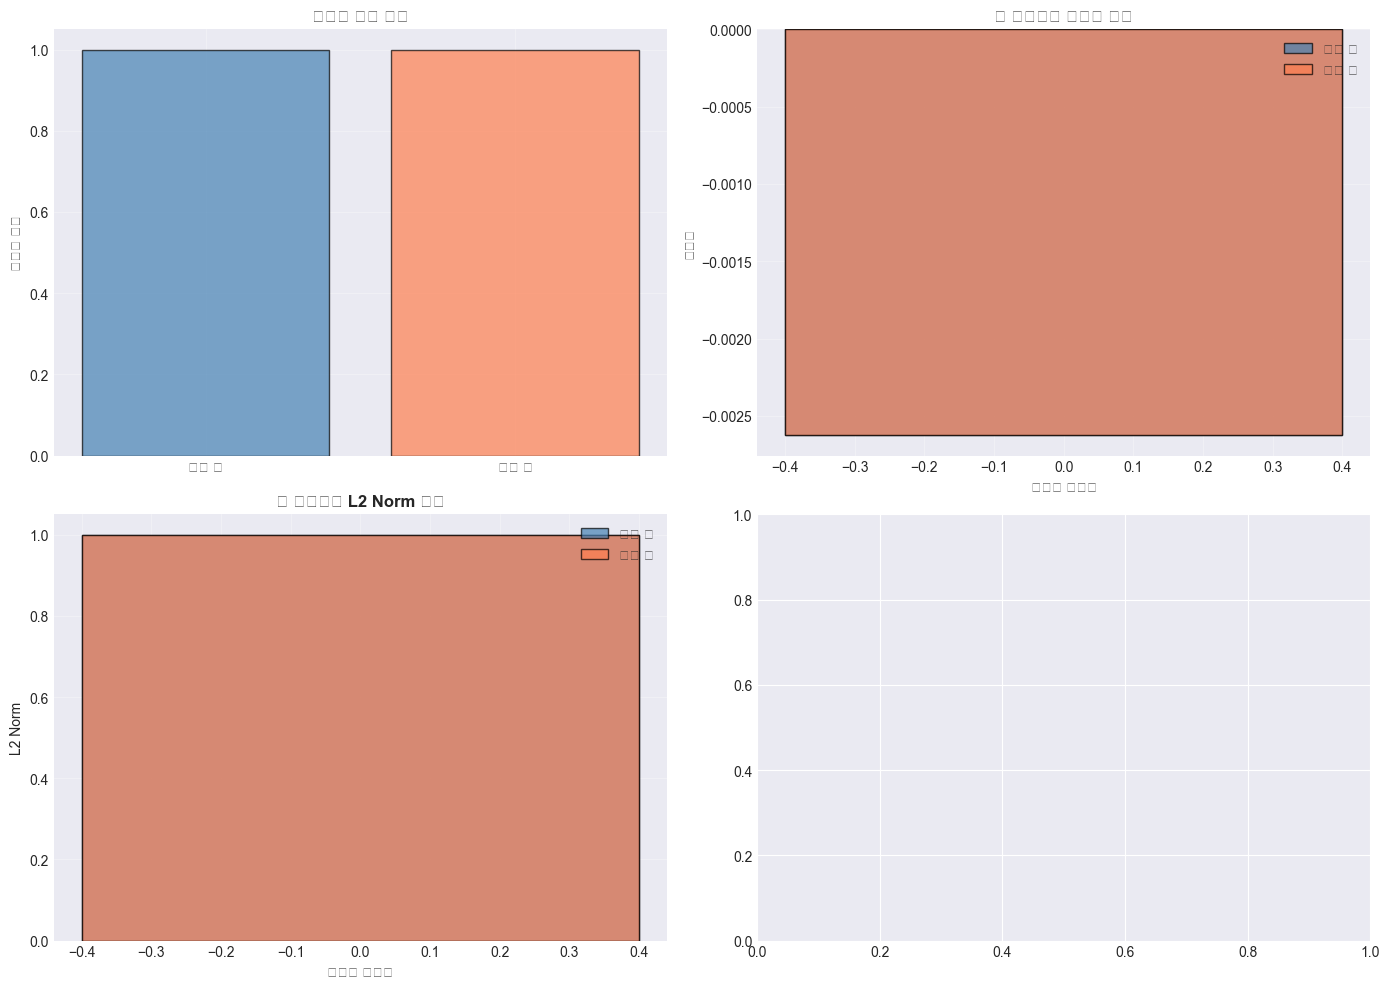

C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\199807206.py:126: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\199807206.py:126: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\199807206.py:126: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\199807206.py:126: UserWarning: Glyph 45937 (\N{HANGUL SYLLABLE DEG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\199807206.py:126: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\199807206.py:126: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) Arial.
  plt.tight_layout(

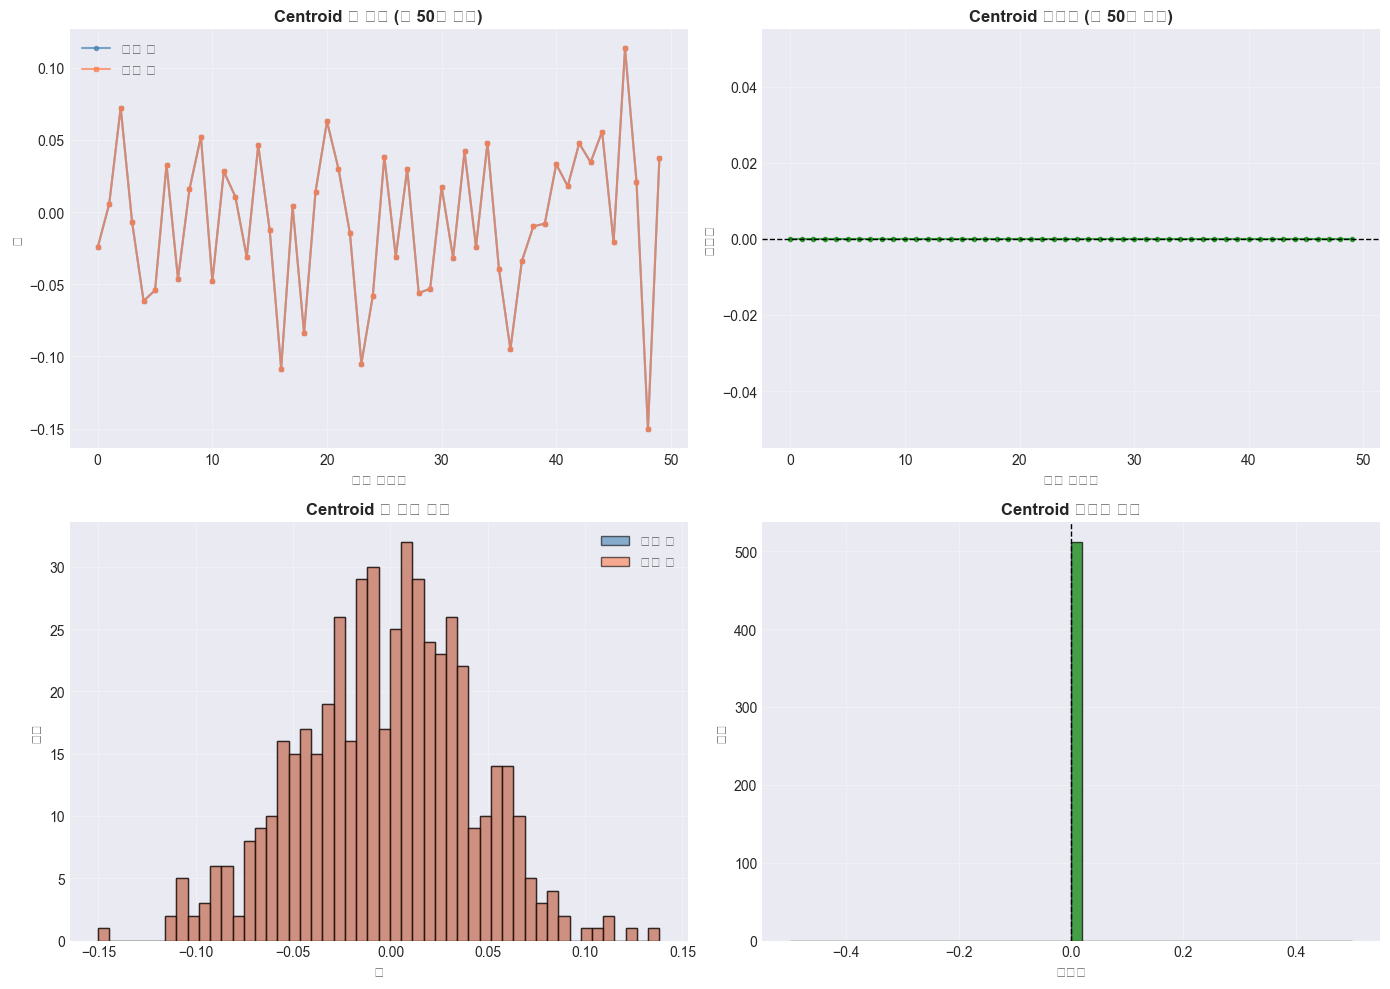


📊 Centroid 변화 통계:
   평균 변화: 0.000000
   표준편차: 0.000000
   최대 증가: 0.000000
   최대 감소: 0.000000
   변화량 L2 norm: 0.000000



In [16]:
# Step 3: 추가 전후 비교 시각화
if bank_before is not None and bank_after is not None:
    print(f"=" * 70)
    print(f"Step 3: 추가 전후 비교 시각화")
    print(f"=" * 70)
    print()
    
    # 1. 임베딩 개수 비교
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1-1. 임베딩 개수 비교
    axes[0, 0].bar(['추가 전', '추가 후'], 
                   [bank_before.shape[0], bank_after.shape[0]], 
                   color=['steelblue', 'coral'], alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('임베딩 개수 비교', fontweight='bold')
    axes[0, 0].set_ylabel('임베딩 개수')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 1-2. 각 임베딩의 평균값 비교
    means_before = bank_before.mean(axis=1)
    means_after = bank_after.mean(axis=1)
    
    x_before = range(len(means_before))
    x_after = range(len(means_after))
    
    axes[0, 1].bar(x_before, means_before, color='steelblue', alpha=0.7, 
                   label='추가 전', edgecolor='black')
    axes[0, 1].bar(x_after, means_after, color='coral', alpha=0.7, 
                   label='추가 후', edgecolor='black')
    axes[0, 1].set_title('각 임베딩의 평균값 비교', fontweight='bold')
    axes[0, 1].set_xlabel('임베딩 인덱스')
    axes[0, 1].set_ylabel('평균값')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 1-3. 각 임베딩의 L2 norm 비교
    norms_before = np.linalg.norm(bank_before, axis=1)
    norms_after = np.linalg.norm(bank_after, axis=1)
    
    axes[1, 0].bar(x_before, norms_before, color='steelblue', alpha=0.7, 
                   label='추가 전', edgecolor='black')
    axes[1, 0].bar(x_after, norms_after, color='coral', alpha=0.7, 
                   label='추가 후', edgecolor='black')
    axes[1, 0].set_title('각 임베딩의 L2 Norm 비교', fontweight='bold')
    axes[1, 0].set_xlabel('임베딩 인덱스')
    axes[1, 0].set_ylabel('L2 Norm')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 1-4. 임베딩 간 유사도 분포 비교
    if bank_before.shape[0] > 1:
        bank_norm_before = bank_before / (np.linalg.norm(bank_before, axis=1, keepdims=True) + 1e-6)
        sim_matrix_before = np.dot(bank_norm_before, bank_norm_before.T)
        mask_before = ~np.eye(sim_matrix_before.shape[0], dtype=bool)
        sims_before = sim_matrix_before[mask_before]
    else:
        sims_before = np.array([])
    
    if bank_after.shape[0] > 1:
        bank_norm_after = bank_after / (np.linalg.norm(bank_after, axis=1, keepdims=True) + 1e-6)
        sim_matrix_after = np.dot(bank_norm_after, bank_norm_after.T)
        mask_after = ~np.eye(sim_matrix_after.shape[0], dtype=bool)
        sims_after = sim_matrix_after[mask_after]
    else:
        sims_after = np.array([])
    
    if len(sims_before) > 0 and len(sims_after) > 0:
        axes[1, 1].hist(sims_before, bins=20, color='steelblue', alpha=0.6, 
                        label='추가 전', edgecolor='black')
        axes[1, 1].hist(sims_after, bins=20, color='coral', alpha=0.6, 
                        label='추가 후', edgecolor='black')
        axes[1, 1].set_title('임베딩 간 유사도 분포 비교', fontweight='bold')
        axes[1, 1].set_xlabel('유사도')
        axes[1, 1].set_ylabel('빈도')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Centroid 변화 시각화
    if centroid_before is not None and centroid_after is not None:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 2-1. Centroid 값 비교 (첫 50개 차원)
        dims = min(50, len(centroid_before))
        axes[0, 0].plot(centroid_before[:dims], 'o-', color='steelblue', 
                       label='추가 전', alpha=0.7, linewidth=1.5, markersize=3)
        axes[0, 0].plot(centroid_after[:dims], 's-', color='coral', 
                       label='추가 후', alpha=0.7, linewidth=1.5, markersize=3)
        axes[0, 0].set_title('Centroid 값 비교 (첫 50개 차원)', fontweight='bold')
        axes[0, 0].set_xlabel('차원 인덱스')
        axes[0, 0].set_ylabel('값')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2-2. Centroid 변화량
        centroid_diff = centroid_after - centroid_before
        axes[0, 1].plot(centroid_diff[:dims], 'o-', color='green', 
                       alpha=0.7, linewidth=1.5, markersize=3)
        axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
        axes[0, 1].set_title('Centroid 변화량 (첫 50개 차원)', fontweight='bold')
        axes[0, 1].set_xlabel('차원 인덱스')
        axes[0, 1].set_ylabel('변화량')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 2-3. Centroid 히스토그램 비교
        axes[1, 0].hist(centroid_before, bins=50, color='steelblue', alpha=0.6, 
                       label='추가 전', edgecolor='black')
        axes[1, 0].hist(centroid_after, bins=50, color='coral', alpha=0.6, 
                       label='추가 후', edgecolor='black')
        axes[1, 0].set_title('Centroid 값 분포 비교', fontweight='bold')
        axes[1, 0].set_xlabel('값')
        axes[1, 0].set_ylabel('빈도')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 2-4. 변화량 히스토그램
        axes[1, 1].hist(centroid_diff, bins=50, color='green', alpha=0.7, edgecolor='black')
        axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=1)
        axes[1, 1].set_title('Centroid 변화량 분포', fontweight='bold')
        axes[1, 1].set_xlabel('변화량')
        axes[1, 1].set_ylabel('빈도')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 통계 출력
        print(f"\n📊 Centroid 변화 통계:")
        print(f"   평균 변화: {centroid_diff.mean():.6f}")
        print(f"   표준편차: {centroid_diff.std():.6f}")
        print(f"   최대 증가: {centroid_diff.max():.6f}")
        print(f"   최대 감소: {centroid_diff.min():.6f}")
        print(f"   변화량 L2 norm: {np.linalg.norm(centroid_diff):.6f}")
    
    # 3. 새로 추가된 임베딩 분석
    if bank_after.shape[0] > bank_before.shape[0]:
        new_embeddings = bank_after[bank_before.shape[0]:]
        print(f"\n📊 새로 추가된 임베딩 분석:")
        print(f"   추가된 임베딩 개수: {new_embeddings.shape[0]}개")
        
        for i, new_emb in enumerate(new_embeddings):
            print(f"\n   새 임베딩 {i+1}:")
            print(f"   - 첫 10개 차원: {new_emb[:10]}")
            print(f"   - 평균: {new_emb.mean():.6f}")
            print(f"   - 표준편차: {new_emb.std():.6f}")
            print(f"   - L2 norm: {np.linalg.norm(new_emb):.6f}")
            
            # 기존 임베딩들과의 유사도
            if bank_before.shape[0] > 0:
                bank_norm_before = bank_before / (np.linalg.norm(bank_before, axis=1, keepdims=True) + 1e-6)
                new_emb_norm = new_emb / (np.linalg.norm(new_emb) + 1e-6)
                similarities = np.dot(bank_norm_before, new_emb_norm)
                print(f"   - 기존 임베딩들과의 유사도: {similarities}")
                print(f"   - 최고 유사도: {similarities.max():.6f}")
                print(f"   - 평균 유사도: {similarities.mean():.6f}")
    
    print()
    print(f"=" * 70)
else:
    print("[ERROR] 추가 전 또는 추가 후 데이터가 없습니다.")
    print("먼저 Step 1과 Step 2를 실행하세요.")


In [17]:
# 각도 정보 확인 (angles.json 파일이 있는 경우)
import json
from collections import Counter

person_id = "jw"
person_dir = emb_dir / person_id
angles_path = person_dir / "angles.json"

if angles_path.exists():
    with open(angles_path, 'r', encoding='utf-8') as f:
        angles_info = json.load(f)
    
    print(f"=" * 70)
    print(f"{person_id} 각도 정보 분석")
    print(f"=" * 70)
    print()
    
    angle_types = angles_info.get("angle_types", [])
    yaw_angles = angles_info.get("yaw_angles", [])
    
    print(f"총 임베딩 개수: {len(angle_types)}개")
    print()
    
    # 각도 타입별 통계
    if angle_types:
        angle_counter = Counter(angle_types)
        print(f"각도 타입별 분포:")
        for angle_type, count in sorted(angle_counter.items(), key=lambda x: x[1], reverse=True):
            percentage = count / len(angle_types) * 100
            print(f"   {angle_type:15s}: {count:4d}개 ({percentage:5.1f}%)")
        print()
        
        # Yaw 각도 통계
        if yaw_angles:
            yaw_array = np.array(yaw_angles)
            print(f"Yaw 각도 통계:")
            print(f"   평균: {yaw_array.mean():.2f}°")
            print(f"   표준편차: {yaw_array.std():.2f}°")
            print(f"   최소: {yaw_array.min():.2f}°")
            print(f"   최대: {yaw_array.max():.2f}°")
            print()
            
            # 각도 분포 히스토그램
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            angle_counts = list(angle_counter.values())
            angle_labels = list(angle_counter.keys())
            plt.bar(angle_labels, angle_counts, color='steelblue', alpha=0.7, edgecolor='black')
            plt.title('각도 타입별 분포', fontweight='bold')
            plt.xlabel('각도 타입')
            plt.ylabel('개수')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 2, 2)
            plt.hist(yaw_array, bins=30, color='coral', alpha=0.7, edgecolor='black')
            plt.axvline(x=0, color='red', linestyle='--', linewidth=1, label='정면 (0°)')
            plt.title('Yaw 각도 분포', fontweight='bold')
            plt.xlabel('Yaw 각도 (도)')
            plt.ylabel('빈도')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # 각도별 임베딩 인덱스
            print(f"각도별 임베딩 인덱스:")
            for angle_type in sorted(set(angle_types)):
                indices = [i for i, a in enumerate(angle_types) if a == angle_type]
                print(f"   {angle_type:15s}: {indices[:10]}{'...' if len(indices) > 10 else ''} (총 {len(indices)}개)")
    else:
        print("각도 정보가 없습니다.")
else:
    print(f"[INFO] 각도 정보 파일이 없습니다: {angles_path}")
    print("      (이전 버전에서는 각도 정보를 저장하지 않았을 수 있습니다)")
    print("      앞으로 Bank에 추가할 때는 각도 정보가 함께 저장됩니다.")

print()
print(f"=" * 70)


[INFO] 각도 정보 파일이 없습니다: outputs\embeddings\jw\angles.json
      (이전 버전에서는 각도 정보를 저장하지 않았을 수 있습니다)
      앞으로 Bank에 추가할 때는 각도 정보가 함께 저장됩니다.



In [18]:
hani_emb.shape

(1, 512)

📊 동적 Bank 각도별 임베딩 분석


👤 danielle
📚 Base Bank: 1개 임베딩
🔄 Dynamic Bank: 없음 (아직 수집되지 않음)

👤 hani
📚 Base Bank: 1개 임베딩
🔄 Dynamic Bank: 없음 (아직 수집되지 않음)

👤 harin
📚 Base Bank: 1개 임베딩
🔄 Dynamic Bank: 없음 (아직 수집되지 않음)

👤 hong
📚 Base Bank: 1개 임베딩
🔄 Dynamic Bank: 없음 (아직 수집되지 않음)

👤 hyein
📚 Base Bank: 1개 임베딩
🔄 Dynamic Bank: 없음 (아직 수집되지 않음)

👤 ja
📚 Base Bank: 1개 임베딩
🔄 Dynamic Bank: 37개 임베딩

📐 각도별 분포:
   front          :   1개
   left           :   3개
   left_profile   :  33개

📋 각도별 상세 정보:

   [front]
      개수: 1개
      인덱스: [24]
      Yaw 각도 범위: -8.2° ~ -8.2°
      평균 Yaw: -8.2°

   [left]
      개수: 3개
      인덱스: [22, 23, 36]
      Yaw 각도 범위: -36.7° ~ -21.1°
      평균 Yaw: -30.5°

   [left_profile]
      개수: 33개
      인덱스: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...
      Yaw 각도 범위: -195.2° ~ -51.2°
      평균 Yaw: -81.0°

✅ 수집 완료 상태:
   완료 여부: 진행 중
   필수 각도: ['front', 'left', 'right', 'top']

   필수 각도별 수집 현황:
      ✅ front     : 1개 수집
      ✅ left      : 3개 수집
      ❌ right     : 0개 수집
      ❌ top       : 0개 수집


C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\675195529.py:136: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\675195529.py:136: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\675195529.py:136: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\675195529.py:136: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\675195529.py:136: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_63028\675195529.py:136: UserWarning: Glyph 48288 (\N{HANGUL SYLLABLE BE}) missing from font(s) Arial.
  plt.tight_layout()
C:\

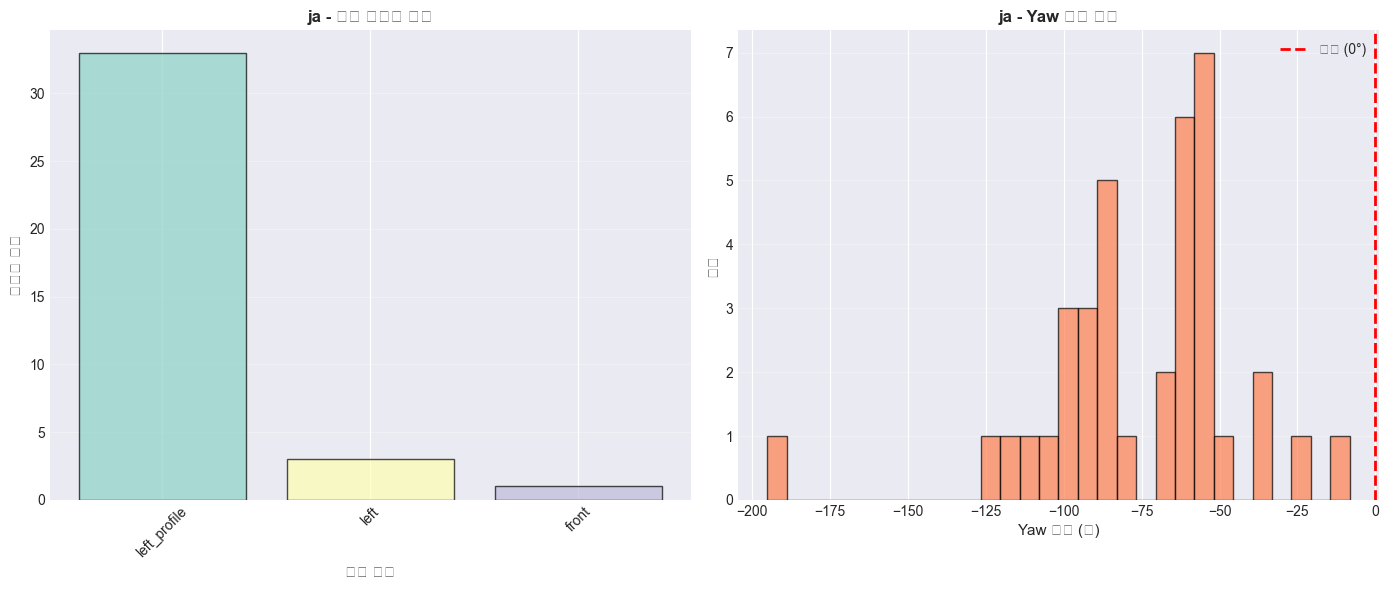


👤 js
📚 Base Bank: 1개 임베딩
🔄 Dynamic Bank: 8개 임베딩

📐 각도별 분포:
   front          :   2개
   left           :   2개
   right          :   3개
   top            :   1개

📋 각도별 상세 정보:

   [front]
      개수: 2개
      인덱스: [0, 1]
      Yaw 각도 범위: -6.1° ~ -5.3°
      평균 Yaw: -5.7°

   [left]
      개수: 2개
      인덱스: [5, 6]
      Yaw 각도 범위: -21.7° ~ -20.0°
      평균 Yaw: -20.8°

   [right]
      개수: 3개
      인덱스: [2, 3, 4]
      Yaw 각도 범위: 15.6° ~ 36.8°
      평균 Yaw: 28.8°

   [top]
      개수: 1개
      인덱스: [7]
      Yaw 각도 범위: -46.8° ~ -46.8°
      평균 Yaw: -46.8°

✅ 수집 완료 상태:
   완료 여부: 완료
   완료 시간: 2025-11-25T14:04:09.127716
   필수 각도: ['front', 'left', 'right', 'top']

   필수 각도별 수집 현황:
      ✅ front     : 2개 수집
      ✅ left      : 2개 수집
      ✅ right     : 3개 수집
      ✅ top       : 1개 수집


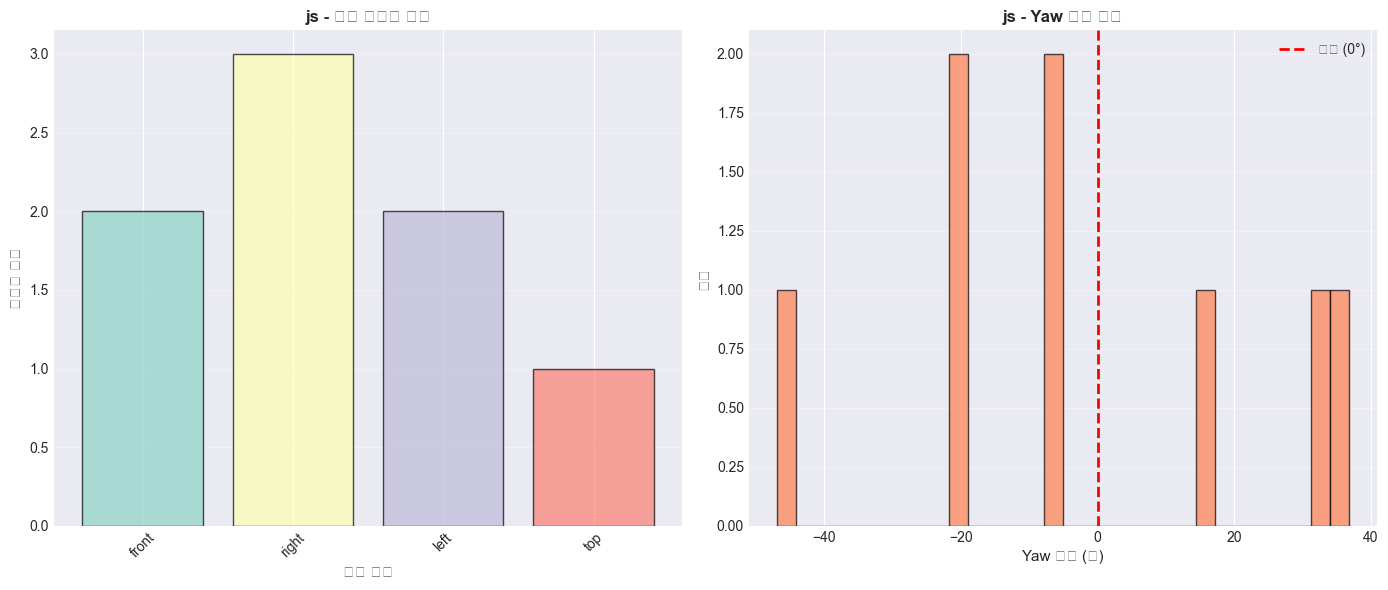


👤 jw
📚 Base Bank: 1개 임베딩
🔄 Dynamic Bank: 17개 임베딩

📐 각도별 분포:
   front          :   2개
   left           :   3개
   left_profile   :   7개
   right          :   3개
   right_profile  :   2개

📋 각도별 상세 정보:

   [front]
      개수: 2개
      인덱스: [0, 1]
      Yaw 각도 범위: 9.8° ~ 13.7°
      평균 Yaw: 11.8°

   [left]
      개수: 3개
      인덱스: [3, 5, 6]
      Yaw 각도 범위: -38.3° ~ -20.7°
      평균 Yaw: -32.3°

   [left_profile]
      개수: 7개
      인덱스: [4, 9, 10, 11, 13, 14, 16]
      Yaw 각도 범위: -200.0° ~ -60.2°
      평균 Yaw: -118.9°

   [right]
      개수: 3개
      인덱스: [2, 8, 12]
      Yaw 각도 범위: 18.8° ~ 20.0°
      평균 Yaw: 19.4°

   [right_profile]
      개수: 2개
      인덱스: [7, 15]
      Yaw 각도 범위: 45.1° ~ 53.3°
      평균 Yaw: 49.2°

✅ 수집 완료 상태:
   완료 여부: 진행 중
   필수 각도: ['front', 'left', 'right', 'top']

   필수 각도별 수집 현황:
      ✅ front     : 2개 수집
      ✅ left      : 3개 수집
      ✅ right     : 3개 수집
      ❌ top       : 0개 수집


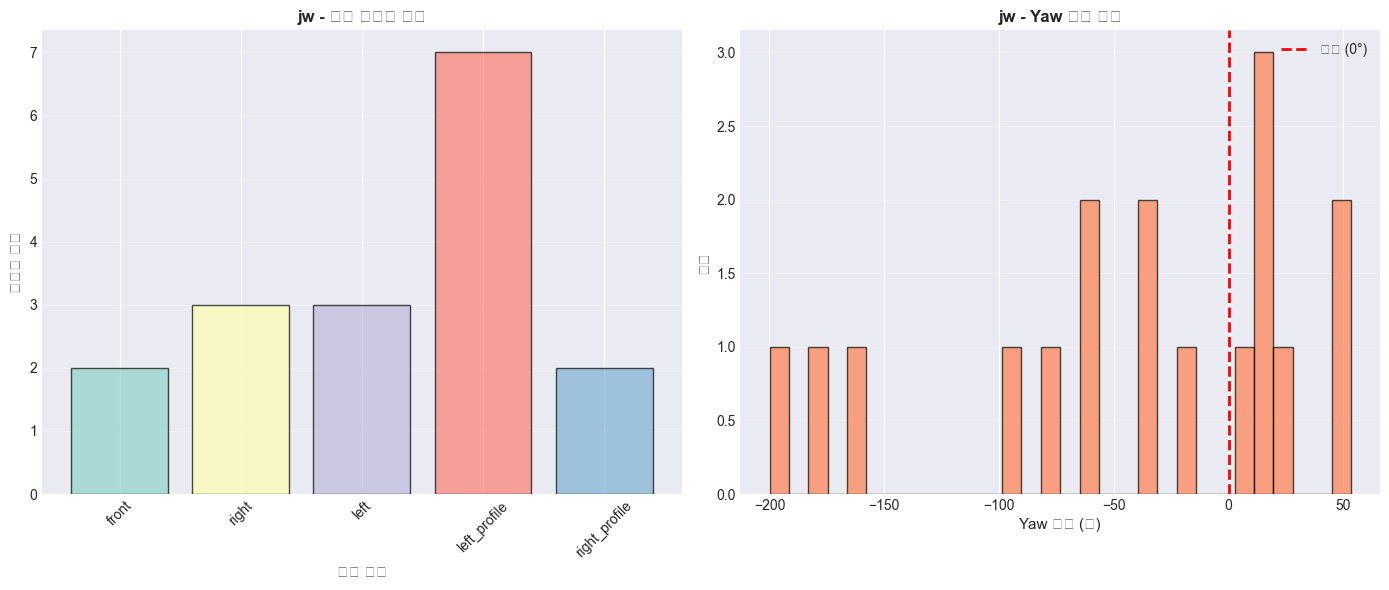


👤 minji
📚 Base Bank: 1개 임베딩
🔄 Dynamic Bank: 없음 (아직 수집되지 않음)

👤 yh
📚 Base Bank: 1개 임베딩
🔄 Dynamic Bank: 40개 임베딩

📐 각도별 분포:
   front          :   2개
   left           :   3개
   left_profile   :   5개
   right          :   3개
   right_profile  :  27개

📋 각도별 상세 정보:

   [front]
      개수: 2개
      인덱스: [5, 6]
      Yaw 각도 범위: 0.0° ~ 3.6°
      평균 Yaw: 1.8°

   [left]
      개수: 3개
      인덱스: [7, 8, 9]
      Yaw 각도 범위: -31.0° ~ -19.3°
      평균 Yaw: -24.6°

   [left_profile]
      개수: 5개
      인덱스: [14, 19, 23, 29, 39]
      Yaw 각도 범위: -123.5° ~ -53.4°
      평균 Yaw: -84.1°

   [right]
      개수: 3개
      인덱스: [0, 12, 13]
      Yaw 각도 범위: 24.1° ~ 38.7°
      평균 Yaw: 32.9°

   [right_profile]
      개수: 27개
      인덱스: [1, 2, 3, 4, 10, 11, 15, 16, 17, 18]...
      Yaw 각도 범위: 45.4° ~ 329.3°
      평균 Yaw: 91.3°

✅ 수집 완료 상태:
   완료 여부: 진행 중
   필수 각도: ['front', 'left', 'right', 'top']

   필수 각도별 수집 현황:
      ✅ front     : 2개 수집
      ✅ left      : 3개 수집
      ✅ right     : 3개 수집
      ❌ top       : 0개 수집


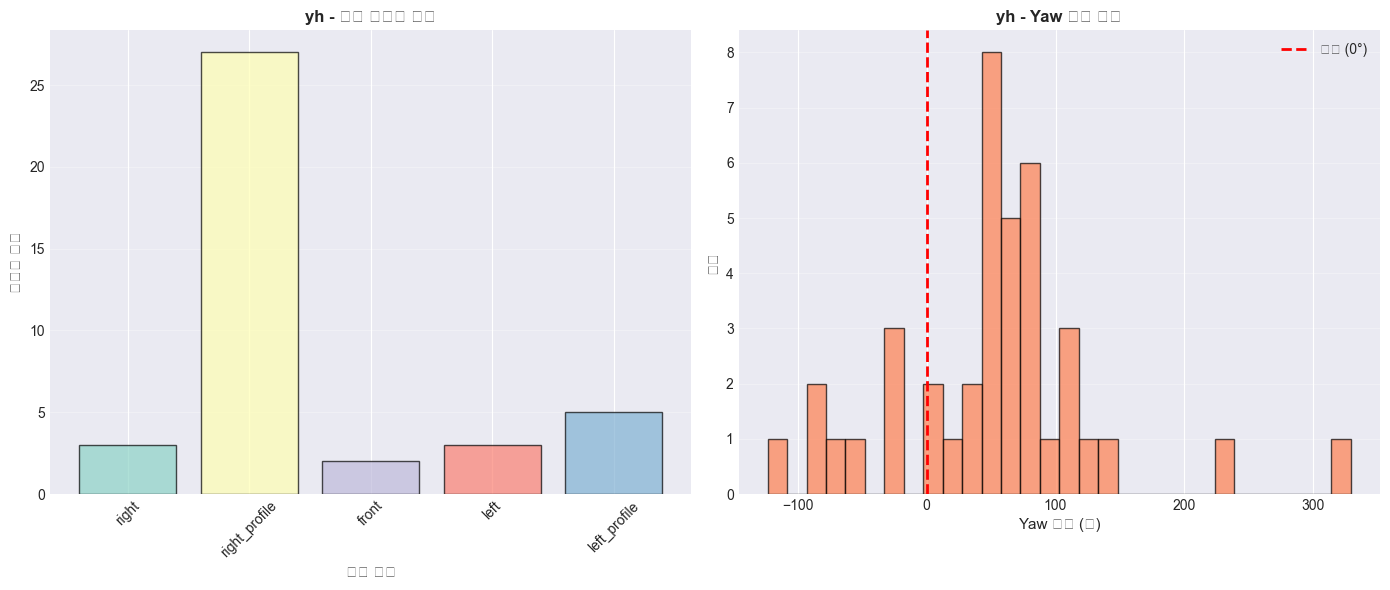


👤 yujin
📚 Base Bank: 1개 임베딩
🔄 Dynamic Bank: 없음 (아직 수집되지 않음)

✅ 분석 완료


In [19]:
# 수집된 여러 각도의 임베딩 확인 (동적 Bank 분석)

import json
from collections import Counter, defaultdict

print("=" * 70)
print("📊 동적 Bank 각도별 임베딩 분석")
print("=" * 70)
print()

emb_dir = Path("outputs/embeddings")

if not emb_dir.exists():
    print(f"[ERROR] 임베딩 폴더를 찾을 수 없음: {emb_dir}")
else:
    person_dirs = [d for d in emb_dir.iterdir() if d.is_dir()]
    
    if not person_dirs:
        print("등록된 인물이 없습니다.")
    else:
        # 각 인물별로 동적 bank 확인
        for person_dir in sorted(person_dirs):
            person_id = person_dir.name
            
            # 동적 bank 파일 경로
            bank_dynamic_path = person_dir / "bank_dynamic.npy"
            angles_path = person_dir / "angles_dynamic.json"
            collection_status_path = person_dir / "collection_status.json"
            bank_base_path = person_dir / "bank_base.npy"
            
            print(f"\n{'='*70}")
            print(f"👤 {person_id}")
            print(f"{'='*70}")
            
            # Base bank 확인
            if bank_base_path.exists():
                base_bank = np.load(bank_base_path)
                if base_bank.ndim == 1:
                    base_bank = base_bank.reshape(1, -1)
                print(f"📚 Base Bank: {base_bank.shape[0]}개 임베딩")
            else:
                print(f"📚 Base Bank: 없음")
            
            # 동적 bank 확인
            if bank_dynamic_path.exists():
                dynamic_bank = np.load(bank_dynamic_path)
                if dynamic_bank.ndim == 1:
                    dynamic_bank = dynamic_bank.reshape(1, -1)
                print(f"🔄 Dynamic Bank: {dynamic_bank.shape[0]}개 임베딩")
                
                # 각도 정보 확인
                if angles_path.exists():
                    with open(angles_path, 'r', encoding='utf-8') as f:
                        angles_info = json.load(f)
                    
                    angle_types = angles_info.get("angle_types", [])
                    yaw_angles = angles_info.get("yaw_angles", [])
                    
                    if angle_types:
                        print(f"\n📐 각도별 분포:")
                        angle_counter = Counter(angle_types)
                        for angle_type, count in sorted(angle_counter.items()):
                            print(f"   {angle_type:15s}: {count:3d}개")
                        
                        # 각도별 상세 정보
                        print(f"\n📋 각도별 상세 정보:")
                        angle_groups = defaultdict(list)
                        for i, (angle_type, yaw) in enumerate(zip(angle_types, yaw_angles)):
                            angle_groups[angle_type].append({
                                "index": i,
                                "yaw_angle": yaw
                            })
                        
                        for angle_type in sorted(angle_groups.keys()):
                            group = angle_groups[angle_type]
                            yaw_values = [g["yaw_angle"] for g in group]
                            print(f"\n   [{angle_type}]")
                            print(f"      개수: {len(group)}개")
                            print(f"      인덱스: {[g['index'] for g in group[:10]]}{'...' if len(group) > 10 else ''}")
                            print(f"      Yaw 각도 범위: {min(yaw_values):.1f}° ~ {max(yaw_values):.1f}°")
                            print(f"      평균 Yaw: {np.mean(yaw_values):.1f}°")
                        
                        # 수집 완료 상태 확인
                        if collection_status_path.exists():
                            with open(collection_status_path, 'r', encoding='utf-8') as f:
                                collection_status = json.load(f)
                            
                            is_completed = collection_status.get("is_completed", False)
                            required_angles = collection_status.get("required_angles", [])
                            collected_angles = collection_status.get("collected_angles", [])
                            
                            print(f"\n✅ 수집 완료 상태:")
                            print(f"   완료 여부: {'완료' if is_completed else '진행 중'}")
                            if collection_status.get("completed_at"):
                                print(f"   완료 시간: {collection_status['completed_at']}")
                            print(f"   필수 각도: {required_angles}")
                            
                            # 각 필수 각도별 수집 여부 확인
                            collected_set = set(collected_angles)
                            print(f"\n   필수 각도별 수집 현황:")
                            for req_angle in required_angles:
                                count = collected_angles.count(req_angle)
                                status = "✅" if count > 0 else "❌"
                                print(f"      {status} {req_angle:10s}: {count}개 수집")
                        else:
                            print(f"\n⚠️ 수집 완료 상태 파일 없음 (아직 수집 시작 전)")
                        
                        # 각도별 분포 시각화
                        if len(angle_types) > 0:
                            plt.figure(figsize=(14, 6))
                            
                            # 각도 타입별 분포
                            plt.subplot(1, 2, 1)
                            angle_counts = Counter(angle_types)
                            angle_labels = list(angle_counts.keys())
                            angle_values = list(angle_counts.values())
                            colors = plt.cm.Set3(range(len(angle_labels)))
                            plt.bar(angle_labels, angle_values, color=colors, alpha=0.7, edgecolor='black')
                            plt.title(f'{person_id} - 각도 타입별 분포', fontweight='bold', fontsize=12)
                            plt.xlabel('각도 타입', fontsize=11)
                            plt.ylabel('임베딩 개수', fontsize=11)
                            plt.xticks(rotation=45)
                            plt.grid(True, alpha=0.3, axis='y')
                            
                            # Yaw 각도 분포
                            plt.subplot(1, 2, 2)
                            yaw_array = np.array(yaw_angles)
                            plt.hist(yaw_array, bins=30, color='coral', alpha=0.7, edgecolor='black')
                            plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='정면 (0°)')
                            plt.title(f'{person_id} - Yaw 각도 분포', fontweight='bold', fontsize=12)
                            plt.xlabel('Yaw 각도 (도)', fontsize=11)
                            plt.ylabel('빈도', fontsize=11)
                            plt.legend()
                            plt.grid(True, alpha=0.3, axis='y')
                            
                            plt.tight_layout()
                            plt.show()
                    else:
                        print(f"   각도 정보가 비어있습니다.")
                else:
                    print(f"   ⚠️ 각도 정보 파일 없음: {angles_path}")
            else:
                print(f"🔄 Dynamic Bank: 없음 (아직 수집되지 않음)")
        
        print(f"\n{'='*70}")
        print(f"✅ 분석 완료")
        print(f"{'='*70}")



In [21]:
jw_bank_dynamic = np.load("C:\\FaceWatch\\outputs\\embeddings\\jw\\bank_dynamic.npy")

In [22]:
jw_bank_dynamic

array([[ 6.3041784e-03,  3.6359595e-03,  3.5456050e-02, ...,
         2.6918061e-03, -6.7416348e-02,  4.6011496e-02],
       [-4.4126119e-02, -1.9787066e-03,  1.1453374e-01, ...,
        -1.7076390e-02, -7.2295676e-05,  3.2789625e-02],
       [-2.6298128e-02,  1.2250114e-02,  4.7994643e-02, ...,
        -3.9196070e-02, -2.8257452e-02, -3.5838179e-02],
       ...,
       [-2.3821887e-02, -1.1161677e-02,  3.4603879e-02, ...,
         1.0934400e-02, -9.8122936e-03, -1.2063092e-02],
       [-4.5238105e-03,  1.1559168e-02,  7.9401843e-02, ...,
         2.2408722e-02, -2.5501933e-02,  1.6930476e-02],
       [-9.2252135e-02,  8.0612235e-02,  7.6003715e-02, ...,
         3.5493720e-02,  2.5515861e-03,  3.5384544e-03]], dtype=float32)

In [23]:
jw_bank_dynamic.shape

(17, 512)